<h3>Data Source</h3>
<ul>
    <li><a href="https://tsapps.nist.gov/NRBTD/Studies/Search">NBTRD Home</a></li>
    <ul>
        <li><a href="https://drive.google.com/drive/folders/1WoEfuRaK832Rv2ttCJSOuVkAVMuzU15C?usp=drive_link">Objective</a></li>
    </ul>
</ul>

### Architecture of my U-Net Training Model (Image Segmentation)

<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="text-align: center;">
        <img src='logs_train.png' alt='Logs Train Image' height='600px' width='600px'>
        <p><b>Resulted Tensorboard Graph</b></p>
    </div>
    <div style="text-align: center;">
        <img src='unet.png' alt='UNet Image' height='600px' width='600px'>
        <p><b>Proposed Architecture for Traning model</b></p>
    </div>
    
</div>



<h3> Sample Image From Trained Dataset (Labelled using: <a href="https://labelstud.io/">Label Studio</a> )</h3>

<div style="display: flex; justify-content: space-around; align-items: center;">
    <div style="text-align: center;">
        <img src='original.png' alt='Original Image'height='400px' width='400px'>
        <p><b>Original Image from Data Source</b></p>
    </div>
    <div style="text-align: center;">
        <img src='masked.png' alt='Masked Image' height='400px' width='400px'>
        <p><b>Masked Image using Label Studio</b></p>
    </div>
    
</div>

### Importing Modules

In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from random import randint
from PIL import Image
from datetime import datetime
import random
import os

### Image Resizing for U-Net Architure (128,128,3)

In [2]:
train_path = './Stage1_train/'
test_path = "./Stage1_test/"

In [3]:
img_width = 128
img_height = 128
channels = 3

In [4]:
class ImagePreprocessor:
    def __init__(self, train_path, test_path, img_height, img_width, channels=3):
        self.train_path = train_path
        self.test_path = test_path
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels

    def _load_and_resize_image(self, img_path):
        grayscale_image = imread(img_path)
        expanded_image = np.expand_dims(grayscale_image, axis=-1)
        img = np.repeat(expanded_image, 3, axis=-1)
        img = resize(img, (self.img_height, self.img_width), mode='constant', preserve_range=True)
        return img

    def _load_and_process_mask(self, mask_path):
        mask_ = imread(mask_path)
        mask_ = np.expand_dims(resize(mask_, (self.img_height, self.img_width), mode='constant', preserve_range=True), axis=-1)
        return mask_

    def _process_data(self, ids, data_path, is_train=True):
        data = np.zeros((len(ids), self.img_height, self.img_width, self.channels), dtype=np.uint8)
        labels = np.zeros((len(ids), self.img_height, self.img_width, 1), dtype=bool)

        print(f"Resizing {'training' if is_train else 'test'} masks and/or only images.")
        for i, id_ in tqdm(enumerate(ids), total=len(ids)):
            path = os.path.join(data_path, id_)
            img_path = os.path.join(path, 'images', f'{id_}.png')

            img = self._load_and_resize_image(img_path)
            data[i] = img

            if is_train:
                mask_path = os.path.join(path, 'masks')
                mask = np.zeros((self.img_height, self.img_width, 1), dtype=bool)
                for mask_file in os.listdir(mask_path):
                    mask_file_path = os.path.join(mask_path, mask_file)
                    mask_ = self._load_and_process_mask(mask_file_path)
                    mask = np.maximum(mask, mask_)
                labels[i] = mask

        return data, labels

    def process_train_data(self):
        train_ids = next(os.walk(self.train_path))[1]
        X_train, y_train = self._process_data(train_ids, self.train_path, is_train=True)
        return X_train, y_train

    def process_test_data(self):
        test_ids = next(os.walk(self.test_path))[1]
        X_test, sizes_test = self._process_data(test_ids, self.test_path, is_train=False)
        return X_test, sizes_test


Image_preprocessor = ImagePreprocessor(train_path, test_path, img_height, img_width)
X_train, y_train = Image_preprocessor.process_train_data()
X_test, sizes_test = Image_preprocessor.process_test_data()

print('Done!')

Resizing training masks and/or only images.


100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:18<00:00,  3.79s/it]


Resizing test masks and/or only images.


100%|██████████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.61s/it]

Done!


In [5]:
def UnetModel(input_shape=(img_height, img_width, channels)):
    inputs = Input(input_shape)
    x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #Bottleneck
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Compiling the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

In [6]:
unet_model = UnetModel(input_shape=(img_height, img_width, channels))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [7]:
unet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
callbacks = [
    ModelCheckpoint('model_for_cartridge.h5', verbose=1, save_best_only=True),
    EarlyStopping(patience=5, monitor='val_loss'),
    TensorBoard(log_dir='logs')
]

In [9]:
# Model training
history = unet_model.fit(X_train, y_train,validation_split=0.1, epochs=100, batch_size=16, callbacks=callbacks)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.6368 - accuracy: 0.7600
Epoch 1: val_loss improved from inf to 0.62705, saving model to model_for_cartridge.h5


C:\Users\shoai\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 14s 2s/step - loss: 0.6368 - accuracy: 0.7600 - val_loss: 0.6270 - val_accuracy: 0.7641
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.7685
Epoch 2: val_loss improved from 0.62705 to 0.56974, saving model to model_for_cartridge.h5
6/6 [==============================] - 10s 2s/step - loss: 0.5972 - accuracy: 0.7685 - val_loss: 0.5697 - val_accuracy: 0.7641
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.4290 - accuracy: 0.7684
Epoch 3: val_loss improved from 0.56974 to 0.32153, saving model to model_for_cartridge.h5
6/6 [==============================] - 10s 2s/step - loss: 0.4290 - accuracy: 0.7684 - val_loss: 0.3215 - val_accuracy: 0.7641
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.3300 - accuracy: 0.7685
Epoch 4: val_loss improved from 0.32153 to 0.30698, saving model to model_for_cartridge.h5
6/6 [==============================] - 10s 2s/step - loss: 0.3300 -

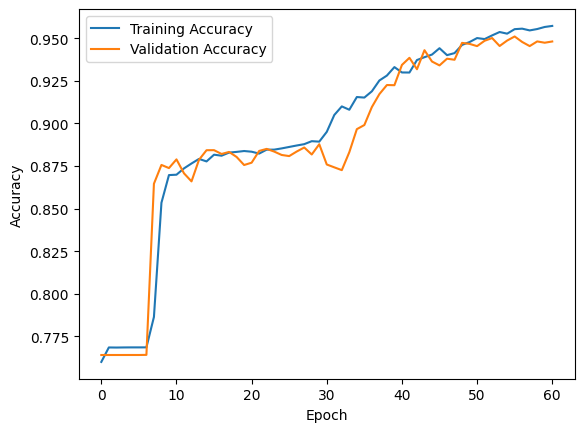

In [10]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
preds_train = unet_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = unet_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = unet_model.predict(X_test, verbose=1)

2/2 [==============================] - 1s 269ms/step


In [12]:
idx = random.randint(0, len(X_train))

In [13]:
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [14]:
def display_images_with_subplots(original, ground_truth, predicted, title_original='Original', title_manual='Manual Mask', title_auto='Auto Masked', figsize=(15, 5), file_name=None):
    for i in range(3):
        ix = random.randint(0, len(predicted))
    
        try:
            fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        
            axes[0].imshow(original[ix], cmap='gray')
            axes[0].set_title(title_original)
        
            axes[1].imshow(np.squeeze(ground_truth[ix]),cmap='gray')
            axes[1].set_title(title_manual)
        
            axes[2].imshow(np.squeeze(predicted[ix]),cmap='gray')
            axes[2].set_title(title_auto)
        
            if file_name:
                plt.savefig(file_name)
            plt.show()
            break
            
        except:
            continue
        

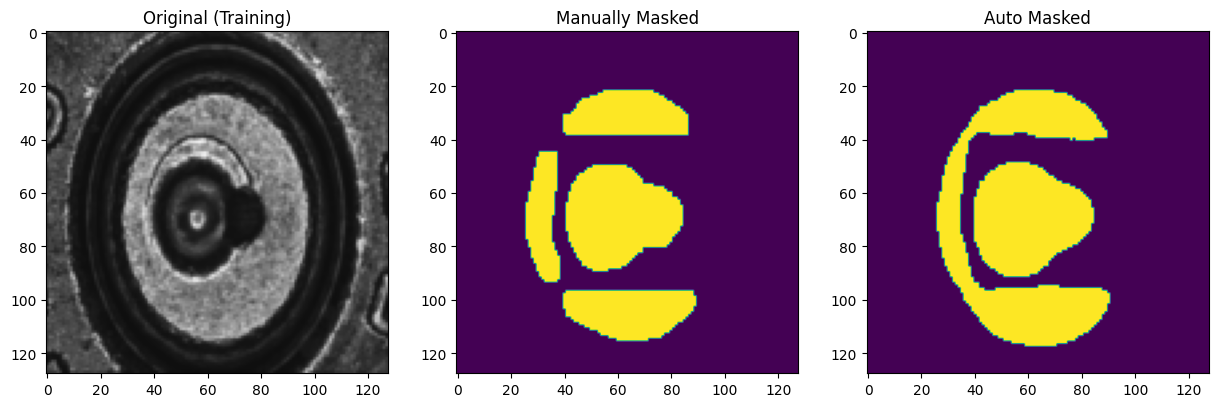

In [15]:
file_name = f'saved_plots/Training_{datetime.now().strftime("%H")}.png'
display_images_with_subplots(X_train, y_train, preds_train_t, title_original='Original (Training)', file_name=file_name)

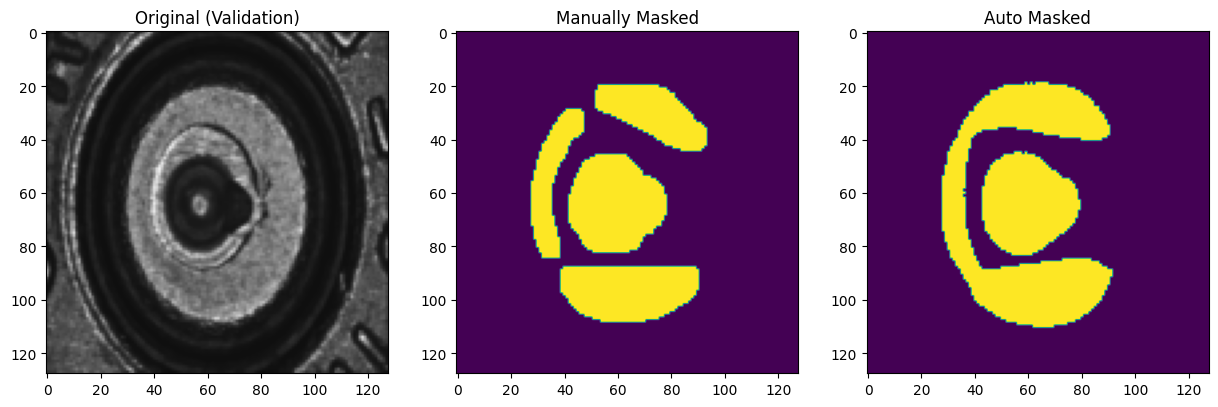

In [16]:
file_name = f'saved_plots/Validation_{datetime.now().strftime("%H")}.png'
display_images_with_subplots(X_train[int(X_train.shape[0]*0.9):], y_train[int(y_train.shape[0]*0.9):], preds_val_t, title_original='Original (Validation)', file_name=file_name)